# [Tutorial: Implementing Layer-Wise Relevance Propagation](http://www.heatmapping.org/tutorial/)
## Tutorial executed by [Elena Ranguelova, NLeSc](https://www.esciencecenter.nl/profile/dr.-elena-ranguelova) 

### Prerequisites

The Python modules [modules.py](http://www.heatmapping.org/tutorial/modules.py.txt) and [utils.py](http://www.heatmapping.org/tutorial/utils.py.txt) were downloaded. Some bugs were fixed (see below) and 
modifications made to run under Python 3.

Also the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Two pre-trained networks for this tutorial were also downloaded: a [fully-connected NN](http://www.heatmapping.org/tutorial/mlp.tar.gz) and a [CNN](http://www.heatmapping.org/tutorial/cnn.tar.gz).

In [17]:
import numpy, copy
import modules as mod
import utils as ut
%matplotlib inline
from IPython.display import Image

## Relevant Propagation for Fully-Connected Networks

Fully-connected network with 2 hidden layers of sizes 300 and 100 and ReLU activations in the hidden layers.

In [18]:
nn = mod.Network([
    mod.Linear('models/mlp/l1'),mod.ReLU(),
    mod.Linear('models/mlp/l2'),mod.ReLU(),
    mod.Linear('models/mlp/l3'),
])

In [19]:
print(nn)

### Implementing the propagation procedure


Extend the `Networks` class from `modules` to have a `relprop` methos.

In [20]:
class Network(mod.Network):
    def relprop(self,R):
        for l in self.layers[::-1]: R = l.relprop(R)
        return R

The LRP considers a pair of linear and ReLU layers as a single 'unified' layer. Implementaiton-wise this can be achieved as propagating the relevance trhough a ReLU without a change.

In [21]:
class ReLU(mod.ReLU):
    def relprop(self,R): return R

Implementing the z+ rule

In [22]:
class NextLinear(mod.Linear):
    def relprop(self,R):
        V = numpy.maximum(0,self.W)
        Z = numpy.dot(self.X,V)+1e-9; 
        S = R/Z;
        C = numpy.dot(S,V.T);         
        R = self.X*C;
        return R

Implementing the zB rule (with input activations the raw pixels?)

In [23]:
class FirstLinear(mod.Linear):
    def relprop(self,R):
        W,V,U = self.W,numpy.maximum(0,self.W),numpy.minimum(0,self.W)
        X,L,H = self.X,self.X*0+ut.lowest,self.X*0+ut.highest

        Z = numpy.dot(X,W)-numpy.dot(L,V)-numpy.dot(H,U)+1e-9; S = R/Z
        R = X*numpy.dot(S,W.T)-L*numpy.dot(S,V.T)-H*numpy.dot(S,U.T)
        return R

### Application to MNIST data

Load MNIST data

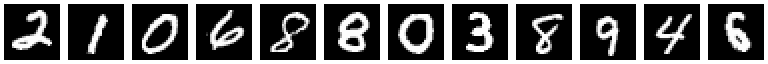

In [24]:
data_path ='/home/elena/eStep/XAI/Data/MNIST'
# NOTE! There is a mistake in the module.py: filenames are with '.', not with '-' in the middle!
# ['t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte', 'train-images.idx3-ubyte', 'train-labels.idx1-ubyte']
X,T = ut.getMNISTsample(N=12,path=data_path,seed=1234)
fname = 'data.png'
ut.visualize(X,ut.graymap,fname)
Image(filename = fname)

Sensitivity analysis

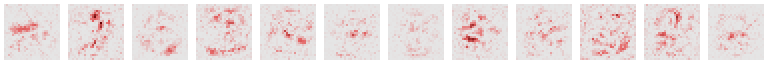

In [25]:
Y = nn.forward(X)
S = nn.gradprop(T)**2
fname = 'mlp-sensitivity.png'
ut.visualize(S,ut.heatmap,fname)
Image(filename = fname)

Relevance propagation: reinstantiate the NN with the new classes

In [26]:
nn = Network([
    FirstLinear('models/mlp/l1'),ReLU(),
    NextLinear('models/mlp/l2'),ReLU(),
    NextLinear('models/mlp/l3'),ReLU(),
])

Run the 3 steps of the global relevance propagation procedure:

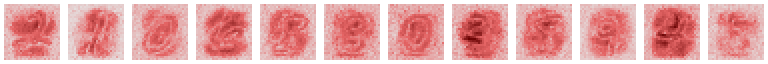

In [27]:
Y = nn.forward(X)
D = nn.relprop(Y*T)
fname = 'mlp-deeptaylor.png'
ut.visualize(D,ut.heatmap,fname)
Image(filename = fname)

## Relevance propagation for CNNs

Lenet-5 with RELUs instead of sigmoid nonlinearities. 

In [28]:
cnn = mod.Network([
    mod.Convolution('models/cnn/c1-5x5x1x10'),mod.ReLU(),mod.Pooling(),
    mod.Convolution('models/cnn/c2-5x5x10x25'),mod.ReLU(),mod.Pooling(),
    mod.Convolution('models/cnn/c3-4x4x25x100'),mod.ReLU(),mod.Pooling(),
    mod.Convolution('models/cnn/c4-1x1x100x10'),
])

### Implementing propagation rules for convolution and pooling

Convolutuion layer. Compare to the Linear layer of a fully connected network above.

In [29]:
class NextConvolution(mod.Convolution):
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)

        Z = pself.forward(self.X)+1e-9; S = R/Z
        C = pself.gradprop(S);          R = self.X*C
        return R

First convolutional layer

In [30]:
class FirstConvolution(mod.Convolution):
    def relprop(self,R):
        iself = copy.deepcopy(self); iself.B *= 0
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = numpy.minimum(0,nself.W)
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)
        X,L,H = self.X,self.X*0+ut.lowest,self.X*0+ut.highest

        Z = iself.forward(X)-pself.forward(L)-nself.forward(H)+1e-9; S = R/Z
        R = X*iself.gradprop(S)-L*pself.gradprop(S)-H*nself.gradprop(S)
        return R

Pooling layer

In [31]:
class Pooling(mod.Pooling):
    def relprop(self,R):
        Z = (self.forward(self.X)+1e-9); S = R / Z
        C = self.gradprop(S);            R = self.X*C
        return R

### Application to MNIST models

Reshaping and padding the input models for the CNN to 32x32x1.

In [32]:
X,T = ut.getMNISTsample(N=12,path= data_path,seed=1234)

padding = ((0,0),(2,2),(2,2),(0,0))
X = numpy.pad(X.reshape([12,28,28,1]),padding,'constant',constant_values=(ut.lowest,))
T = T.reshape([12,1,1,10])

Sensitivity analysis

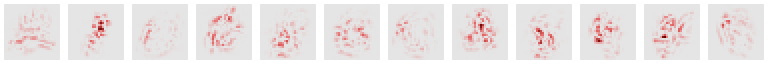

In [33]:
Y = cnn.forward(X)
S = cnn.gradprop(T)**2
fname = 'cnn-sensitivity.png'
ut.visualize(S[:,2:-2,2:-2],ut.heatmap,fname)
Image(filename = fname)

Relevance propagation.

In [34]:
cnn = Network([
    FirstConvolution('models/cnn/c1-5x5x1x10'),ReLU(),Pooling(),
    NextConvolution('models/cnn/c2-5x5x10x25'),ReLU(),Pooling(),
    NextConvolution('models/cnn/c3-4x4x25x100'),ReLU(),Pooling(),
    NextConvolution('models/cnn/c4-1x1x100x10'),ReLU(),
])

Explain the predicitons as heatmaps

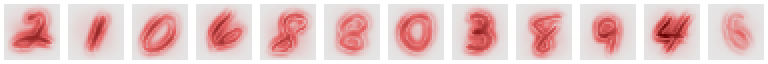

In [35]:
Y = cnn.forward(X)
D = cnn.relprop(Y*T)
fname = 'cnn-deeptaylor.png'
ut.visualize(D[:,2:-2,2:-2],ut.heatmap,fname)
Image(filename=fname)

### Increase focus of explanation with LPR- $\alpha\beta$ rule

Include also negative relevance.

In [36]:
class NextConvolutionAlphaBeta(mod.Convolution,object):

    def __init__(self,name,alpha):
        super(self.__class__, self).__init__(name)
        self.alpha = alpha
        self.beta  = alpha-1
        
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum( 1e-9,pself.W)
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = numpy.minimum(-1e-9,nself.W)

        X = self.X+1e-9
        ZA = pself.forward(X); SA =  self.alpha*R/ZA
        ZB = nself.forward(X); SB = -self.beta *R/ZB
        R = X*(pself.gradprop(SA)+nself.gradprop(SB))
        return R

Illustrate the rule by building a CNN with $\alpha=2$

In [37]:
cnn = Network([
    FirstConvolution('models/cnn/c1-5x5x1x10'),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('models/cnn/c2-5x5x10x25',2.0),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('models/cnn/c3-4x4x25x100',2.0),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('models/cnn/c4-1x1x100x10',2.0),ReLU(),
])

Explanations.

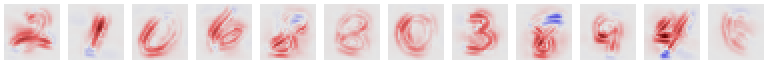

In [38]:
Y = cnn.forward(X)
D = cnn.relprop(Y*T)
fname = 'cnn-alphabeta.png'
ut.visualize(D[:,2:-2,2:-2],ut.heatmap,fname)
Image(filename=fname)